# CDD Semestral Work
### Mu-opioid receptor interacting compounds

Pavlína Slavníková

UCT 2024

### Data preprocessing

In [36]:
# import
import pandas as pd
import numpy as np
import seaborn as sns

from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.Scaffolds import MurckoScaffold

from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn

import umap
import umap.plot

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [37]:
# load data
data = pd.read_csv('mu_data.csv', delimiter=';')

In [38]:
# show column names
for column in list(data):
    print(column, end=' - ')

Molecule ChEMBL ID - Molecule Name - Molecule Max Phase - Molecular Weight - #RO5 Violations - AlogP - Compound Key - Smiles - Standard Type - Standard Relation - Standard Value - Standard Units - pChEMBL Value - Data Validity Comment - Comment - Uo Units - Ligand Efficiency BEI - Ligand Efficiency LE - Ligand Efficiency LLE - Ligand Efficiency SEI - Potential Duplicate - Assay ChEMBL ID - Assay Description - Assay Type - BAO Format ID - BAO Label - Assay Organism - Assay Tissue ChEMBL ID - Assay Tissue Name - Assay Cell Type - Assay Subcellular Fraction - Assay Parameters - Assay Variant Accession - Assay Variant Mutation - Target ChEMBL ID - Target Name - Target Organism - Target Type - Document ChEMBL ID - Source ID - Source Description - Document Journal - Document Year - Cell ChEMBL ID - Properties - Action Type - Standard Text Value - 

In [39]:
print(f'# of muscarine receptor interacting substances with recorded activity: {data['pChEMBL Value'].count()}')

# of muscarine receptor interacting substances with recorded activity: 8469


In [40]:
# select some columns only
mu = data[['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value']].dropna()
mu['Target'] = 'opioid'
mu['Mol'] = mu.apply(lambda row: Chem.MolFromSmiles(row['Smiles']), axis=1)
mu.rename({'pChEMBL Value': 'Activity', 'Molecule ChEMBL ID': 'ID'}, axis=1, inplace=True)

In [41]:
# load background data
background = pd.read_csv('background_drugbank.csv')
background.rename({'smiles': 'Smiles'}, axis=1, inplace=True)
background['Target'] = 'background'
background['Mol'] = background.apply(lambda row: Chem.MolFromSmiles(row['Smiles']), axis=1)

In [42]:
# concat
df = pd.concat([mu, background], ignore_index=True)
df = df[['ID', 'Mol', 'Smiles', 'Activity', 'Target']]
df = df.drop_duplicates(subset='Smiles')

In [43]:
print(f'# of mu-opioid receptor interacting substances after preprocessing: {len(df[df['Target'] == 'opioid'])}')
print(f'# of background substances after preprocessing: {len(df[df['Target'] == 'background'])}')

# of mu-opioid receptor interacting substances after preprocessing: 5820
# of background substances after preprocessing: 3823


Standardization

In [44]:
# taken from lectures
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [45]:
# standardization
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [46]:
# create filter
df_filter = [i for i,mol in enumerate(df['Mol']) if standardize(mol)]
# standardize
df_stand = df.loc[df.index[df_filter]]

In [47]:
print(f'# of mu-opioid receptor interacting substances after standardization: {len(df[df['Target'] == 'opioid'])}')
print(f'# of background substances after standardization: {len(df[df['Target'] == 'background'])}')

# of mu-opioid receptor interacting substances after standardization: 5820
# of background substances after standardization: 3823


In [48]:
# select smaller subsets
m = df[df['Target'] == 'opioid']
b = df[df['Target'] == 'background']
m_subset = m.sample(n=3000)
b_subset = b.sample(n=3000)

# concat
df = pd.concat([m_subset, b_subset], ignore_index=True)

# shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [49]:
df

,ID,Mol,Smiles,Activity,Target
0,CHEMBL1642739,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,NC(=O)c1ccc2c(c1)CCCN2c1ccc(CNCC2CCCCC2)cc1,7.40,opioid
1,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193ACB...,Cn1nc(C(C)(C)C)cc1NC(=O)Nc1ccc(Cl)cc1,NaN,background
2,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAC...,NC[C@H]1CN(c2c(Br)cnc3[nH]ncc23)CCO1,NaN,background
3,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,N=C(N)NC(=N)NCCc1ccccc1,NaN,background
4,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,O=c1nc(O)ccn1[C@@H]1O[C@H](CO)[C@@H](OP(=O)(O)...,NaN,background
...,...,...,...,...,...
5995,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193ACB...,Cn1c(=O)c2c(nc(N3CC[NH2+]CC3)n2Cc2ccccc2)n(C)c1=O,NaN,background
5996,CHEMBL241155,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,COc1ccc(C)c(OC(CCN2CCC(n3c(=O)n(CC(=O)NCCO)c4c...,7.12,opioid
5997,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAC...,FC(F)OC(Cl)C(F)(F)F,NaN,background
5998,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193ACC...,CCCCCCCCCCCCCCCCCCOC[C@@H](CO[P@@](=O)(O)OCCSC...,NaN,background


### Basic descriptors

In [50]:
# add some basic descriptors to the df
df['NumAtoms'] = df.apply(lambda row: row['Mol'].GetNumAtoms(), axis=1)
df['LogP'] = df.apply(lambda row: Descriptors.MolLogP(row['Mol']), axis=1)
df['NumHDonors'] = df.apply(lambda row: Descriptors.NumHDonors(row['Mol']), axis=1)
df['NumHAcceptors'] = df.apply(lambda row: Descriptors.NumHAcceptors(row['Mol']), axis=1)
df['NumRings'] = df.apply(lambda row: Chem.CalcNumRings(row['Mol']), axis=1)
df['NumRotBonds'] = df.apply(lambda row: Chem.CalcNumRotatableBonds(row['Mol']), axis=1)

In [51]:
df

,ID,Mol,Smiles,Activity,Target,NumAtoms,LogP,NumHDonors,NumHAcceptors,NumRings,NumRotBonds
0,CHEMBL1642739,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,NC(=O)c1ccc2c(c1)CCCN2c1ccc(CNCC2CCCCC2)cc1,7.40,opioid,28,4.53970,2,3,4,6
1,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193ACB...,Cn1nc(C(C)(C)C)cc1NC(=O)Nc1ccc(Cl)cc1,NaN,background,21,4.01500,2,3,2,2
2,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAC...,NC[C@H]1CN(c2c(Br)cnc3[nH]ncc23)CCO1,NaN,background,18,0.88430,2,5,3,2
3,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,N=C(N)NC(=N)NCCc1ccccc1,NaN,background,15,0.23654,5,2,1,3
4,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,O=c1nc(O)ccn1[C@@H]1O[C@H](CO)[C@@H](OP(=O)(O)...,NaN,background,21,-2.32260,5,9,2,4
...,...,...,...,...,...,...,...,...,...,...,...
5995,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193ACB...,Cn1c(=O)c2c(nc(N3CC[NH2+]CC3)n2Cc2ccccc2)n(C)c1=O,NaN,background,26,-1.13460,1,7,4,3
5996,CHEMBL241155,<rdkit.Chem.rdchem.Mol object at 0x00000193AAD...,COc1ccc(C)c(OC(CCN2CCC(n3c(=O)n(CC(=O)NCCO)c4c...,7.12,opioid,39,3.35912,2,8,4,12
5997,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193AAC...,FC(F)OC(Cl)C(F)(F)F,NaN,background,10,2.35280,0,1,0,2
5998,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000193ACC...,CCCCCCCCCCCCCCCCCCOC[C@@H](CO[P@@](=O)(O)OCCSC...,NaN,background,35,7.26580,2,6,0,27


In [52]:
df_melt = pd.melt(df, id_vars=['Target'], value_vars=['LogP', 'NumHDonors', 'NumHAcceptors', 'NumRings', 'NumRotBonds'])

<Axes: xlabel='Target', ylabel='NumAtoms'>

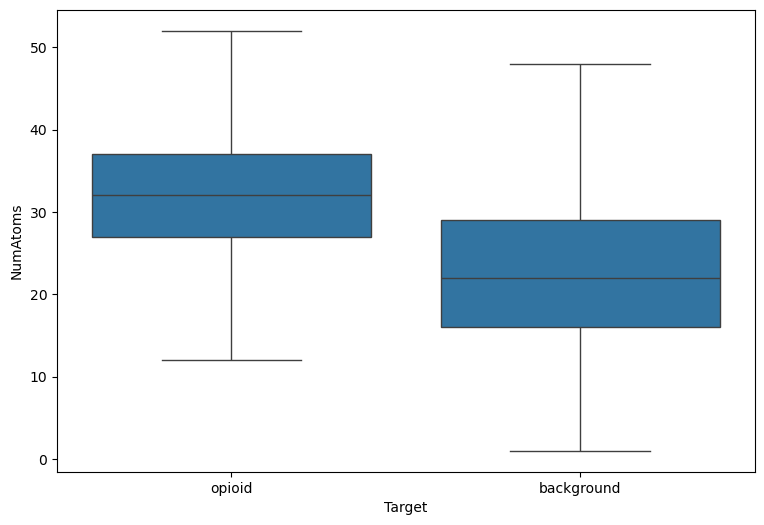

In [53]:
plt.subplots(figsize=(9,6))
sns.boxplot(y='NumAtoms', x='Target', data=df, showfliers=False)

<Axes: xlabel='variable', ylabel='value'>

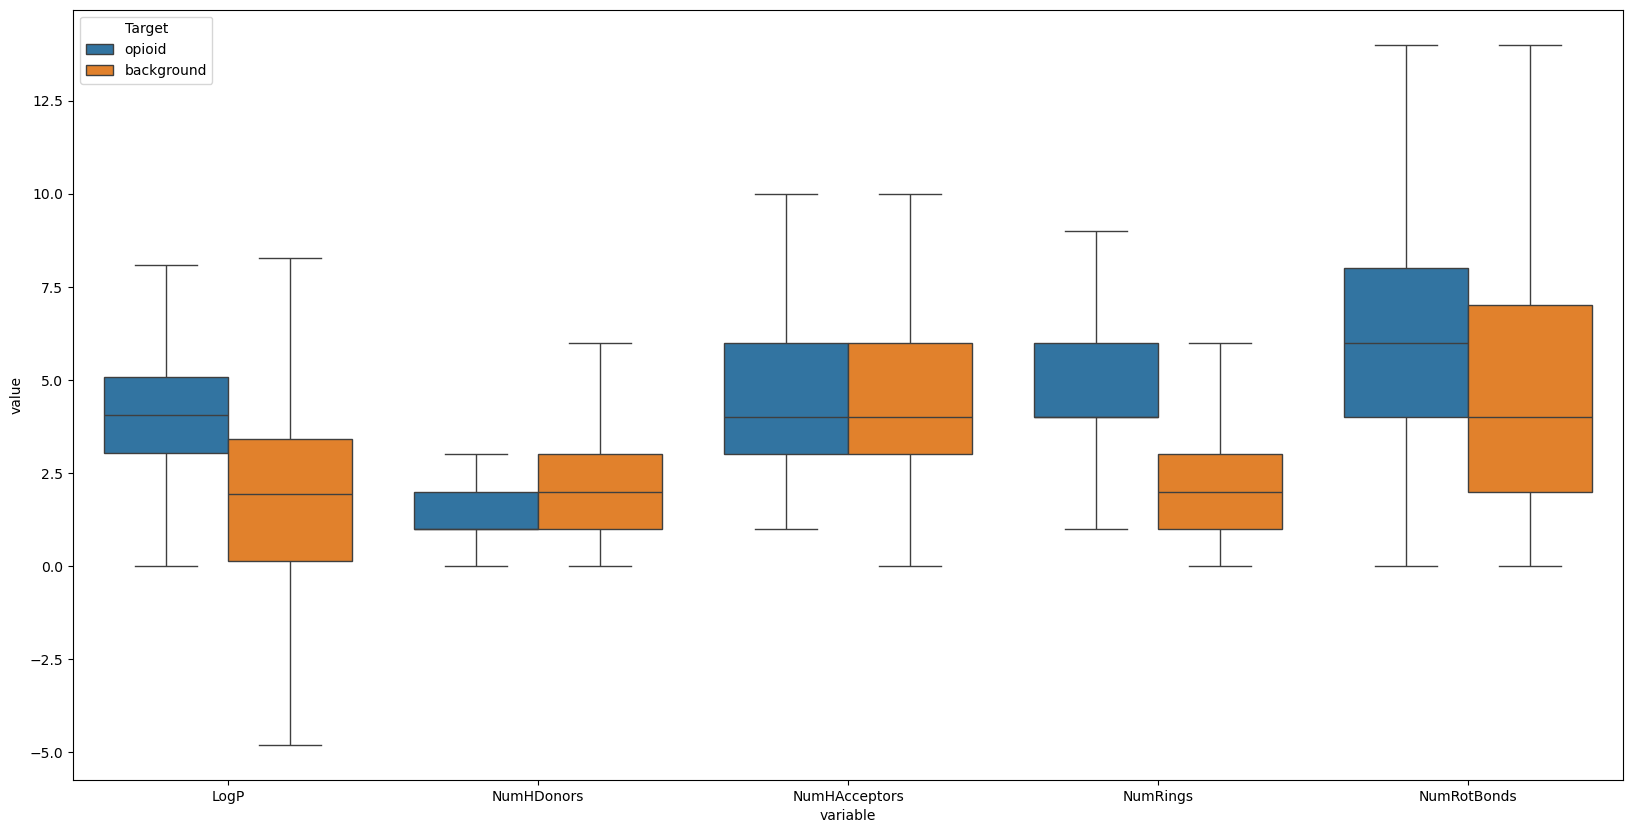

In [54]:
plt.subplots(figsize=(20,10))
sns.boxplot(y='value', x='variable', hue='Target', data=df_melt, showfliers=False)

## Scaffold Analysis

In [61]:
# add scaffolds to df
df['Scaffold'] = df.apply(lambda row: MurckoScaffold.GetScaffoldForMol(row['Mol']), axis=1)
df['ScaffoldSmiles'] = df.apply(lambda row: Chem.MolToSmiles(row['Scaffold']), axis=1)

print(f'# of unique scaffolds with mu-opioid target: {df[df['Target'] == 'opioid']['ScaffoldSmiles'].nunique()}')

# of unique scaffolds with mu-opioid target: 1616


In [62]:
# get 12 most frequent scaffolds within muscarin receptor target group
scaff_mu = df[df['Target'] == 'opioid'][['ScaffoldSmiles']]
scaff_mu['ScaffoldCounts'] = scaff_mu.groupby('ScaffoldSmiles')['ScaffoldSmiles'].transform('count')
scaff_mu = scaff_mu.sort_values(by='ScaffoldCounts', ascending=False).drop_duplicates(subset='ScaffoldSmiles')[:12]
scaff_mu['ScaffoldMol'] = scaff_mu.apply(lambda row: Chem.MolFromSmiles(row['ScaffoldSmiles']), axis=1)

In [63]:
scaff_mu

,ScaffoldSmiles,ScaffoldCounts,ScaffoldMol
568,c1ccc([C@H]2C[C@H]3CC[C@@H](C2)N3CCNCC2CCCCC2)cc1,34,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
3866,c1ccc(CNCCN2[C@@H]3CC[C@H]2C[C@@H](c2ccccc2)C3...,30,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
5181,c1ccc(C2CCN(C(c3ccccc3)c3ccccc3)CC2)cc1,26,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
4987,c1ccc(COC[C@H]2C[C@@]34CCC2[C@@H]2Oc5cccc6c5[C...,22,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
2627,c1cc2c3c(c1)O[C@H]1C4CCC5(CC4)[C@@H](C2)N(CC2C...,21,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
5967,O=c1cnc2ccccc2n1C1CCN(C2CCCCCCC2)CC1,18,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
3645,O=c1[nH]c2ccccc2n1C1CCN(Cc2ccccc2)CC1,18,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
469,c1ccc(C(c2ccccc2)N2[C@@H]3CC[C@H]2CC(c2ccccn2)...,17,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
4042,c1ccc(C2CCC3(CC2)OCCc2c3[nH]c3ccccc23)cc1,17,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...
4863,O=C1CCC2[C@H]3Cc4ccccc4[C@@]2(CCN3CC2CC2)C1,17,<rdkit.Chem.rdchem.Mol object at 0x00000193AAF...


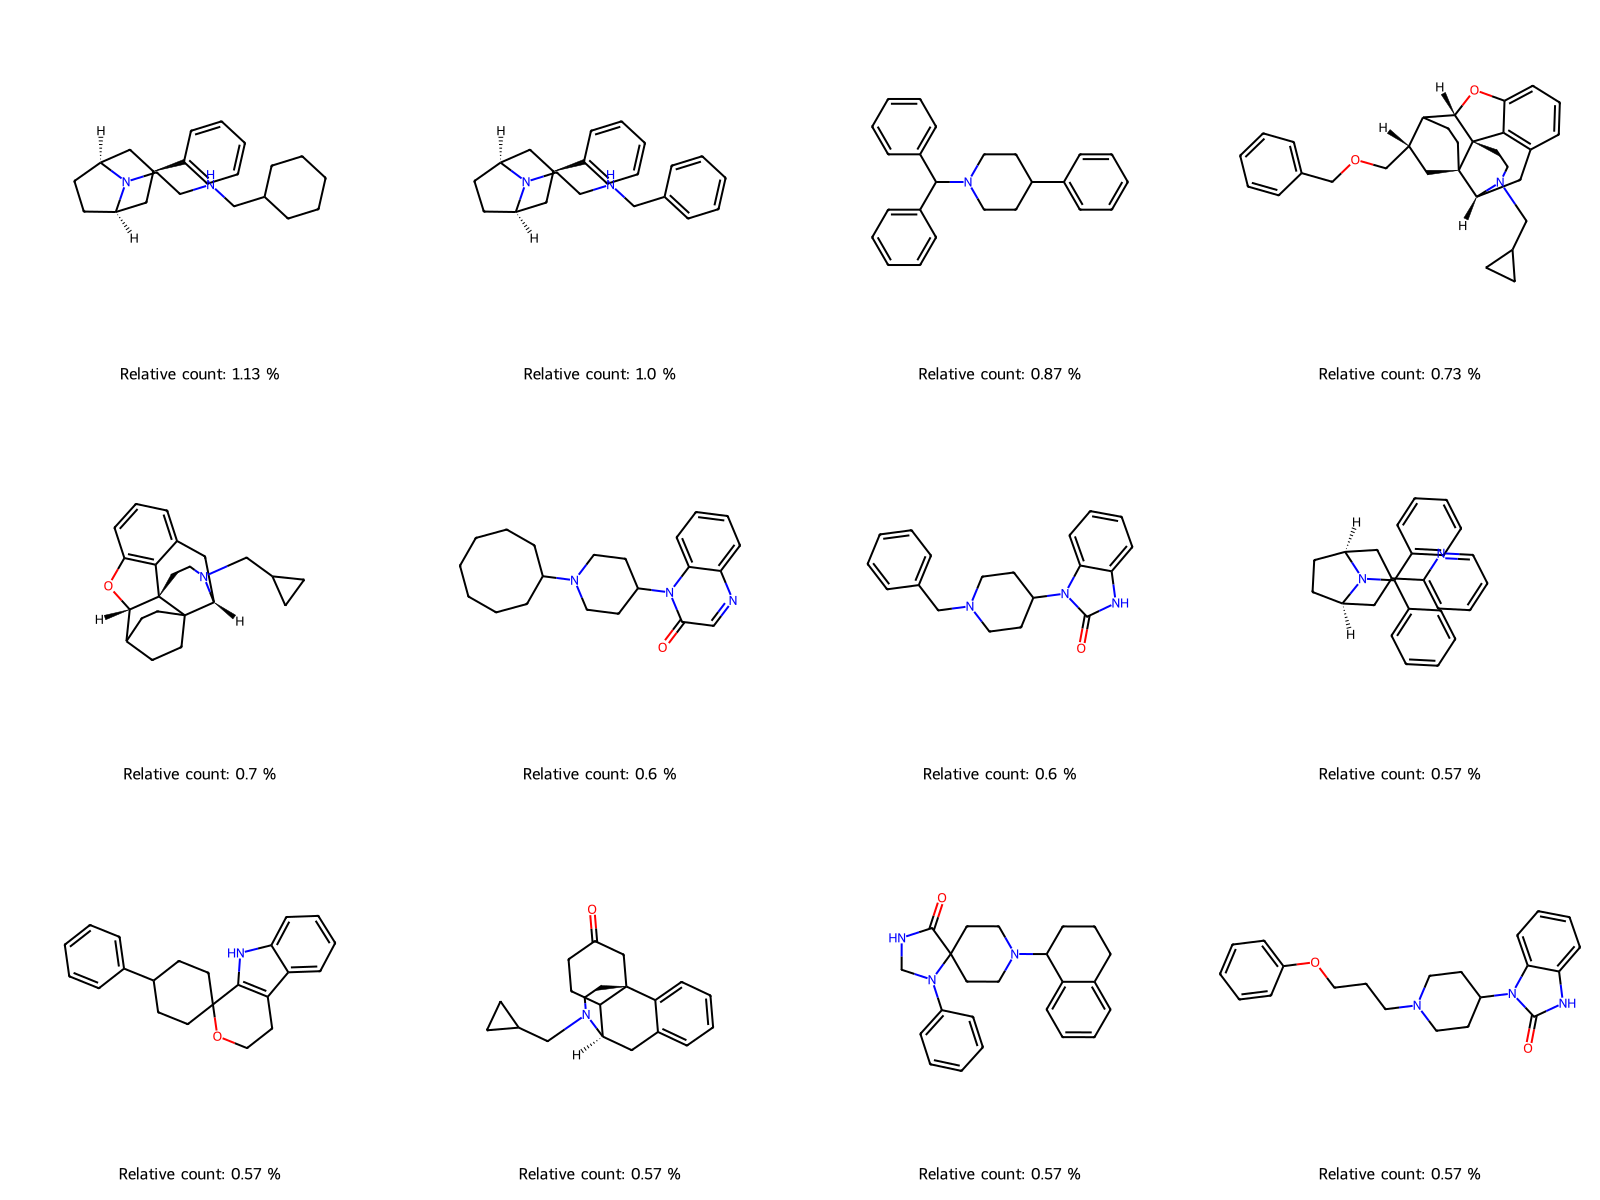

In [68]:
# draw the most frequent scaffolds within mu target group
legends = [f'Relative count: {round((scaff_mu["ScaffoldCounts"].iloc[i] / len(df[df['Target'] == 'opioid']))*100, 2)} %' for i in range(len(scaff_mu))]
Draw.MolsToGridImage([mol for mol in scaff_mu['ScaffoldMol']], molsPerRow=4, subImgSize=(400, 400), legends=legends)


### Data visualization

In [69]:
# add fingerprint columns
df = df.join(pd.DataFrame((rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, 2048).ToList() for mol in df['Mol']), columns=[f'FP_{x}' for x in range(0,2048)]))

In [70]:
# get distance matrix
sparse_mat_FP = distance.pdist(df[[f'FP_{x}' for x in range(0,2048)]], metric="jaccard")
dist_mat_FP = distance.squareform(sparse_mat_FP)

np.save('distance_matrix_FP_op.npy', dist_mat_FP)

In [28]:
dist_mat_FP = np.load('distance_matrix_FP_op.npy')

Visualization through tSNE

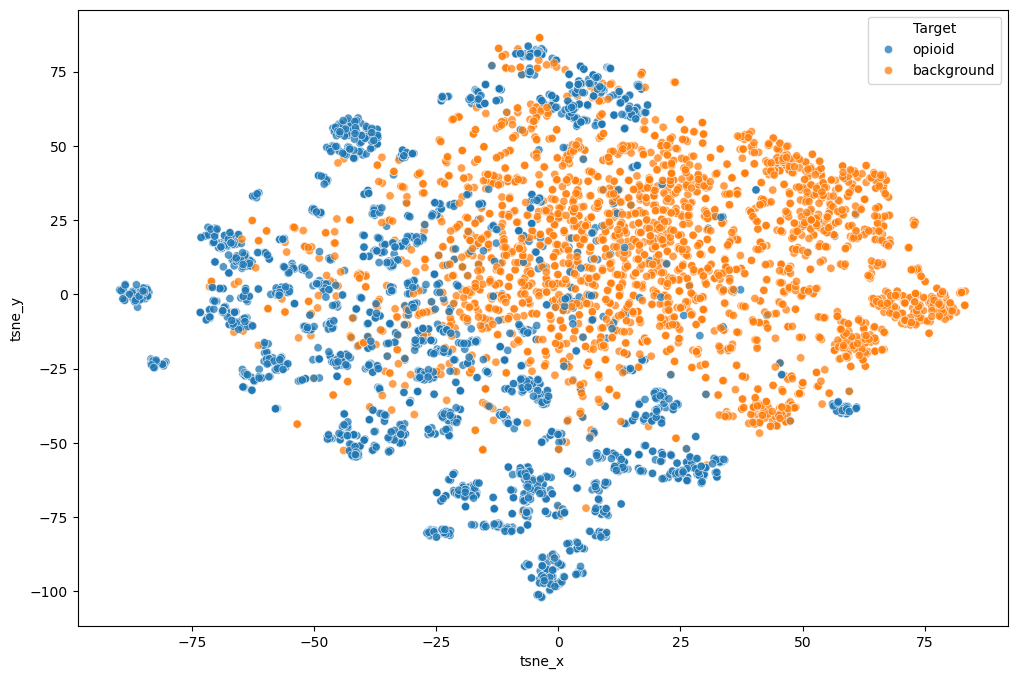

In [84]:
# execute tSNE
clf = manifold.TSNE(n_components=2, metric="precomputed", init="random")
X2_tsne = clf.fit_transform(dist_mat_FP)

# plot the result in 2D
fig, ax = plt.subplots(figsize=(12,8))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.join(pd.DataFrame(X2_tsne, columns=["tsne_x", "tsne_y"])),
                      hue="Target",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [85]:
# execute tSNE
clf = manifold.TSNE(n_components=3, metric="precomputed", init="random")
X3_tsne = clf.fit_transform(dist_mat_FP)

# plot in 3D
fig = px.scatter_3d(
    X3_tsne, x=0, y=1, z=2,
    color=df['Target'], labels={'color': 'target'}
)
fig.update_traces(marker_size=2)
fig.show()

Visualization through UMAP

In [88]:
# # define different parameter values
# n_neighbors_values = [5, 10, 20]
# min_dist_values = [0.0, 0.1, 0.5]

# # create a grid of subplots
# num_rows = len(n_neighbors_values)
# num_cols = len(min_dist_values)
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(17, 15))

# # iterate over each combination of parameters
# for i, n_neighbors in enumerate(n_neighbors_values):
#     for j, min_dist in enumerate(min_dist_values):
#         # execute UMAP with current parameter values
#         reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric='precomputed', init='random')
#         mapper = reducer.fit(dist_mat_FP)
        
#         # plot the result on the corresponding subplot
#         ax = axs[i, j]
#         umap.plot.points(mapper, labels=df['Target'], theme='fire', ax=ax)
#         ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

# plt.tight_layout()
# plt.show()

<Axes: >

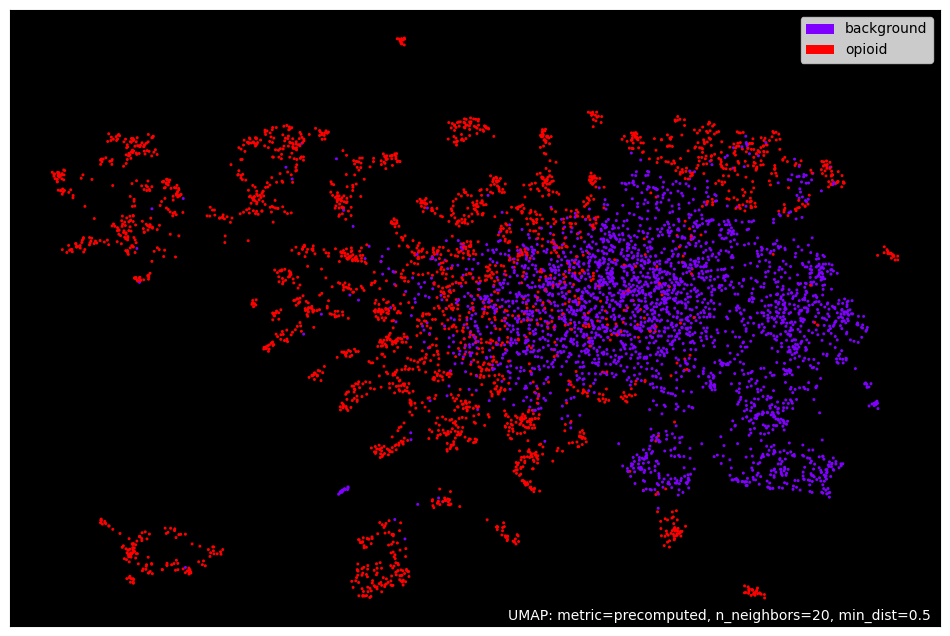

In [86]:
# execute UMAP
reducer = umap.UMAP(n_neighbors=20, min_dist=0.5, metric='precomputed', init='random')
mapper2D = reducer.fit(dist_mat_FP)

# plot in 2D
fig, ax = plt.subplots(figsize=(12,8))
umap.plot.points(mapper2D, labels=df['Target'], theme='fire', ax=ax)

In [93]:
# execute UMAP
reducer = umap.UMAP(n_components=3, n_neighbors=20, min_dist=0.5, metric='precomputed', init='random')
mapper3D = reducer.fit_transform(dist_mat_FP)

# plot in 3D
fig = px.scatter_3d(
    mapper3D, x=0, y=1, z=2,
    color=df['Target'], labels={'color': 'target'}
)

fig.update_traces(marker_size=2)
fig.show()

### RandomForest Target Prediction

In [74]:
# split the data into training and testing
df_train, df_test = train_test_split(df, random_state=42)
mu_train, mu_test = train_test_split(df[df['Target'] == 'opioid'], random_state=42)

In [75]:
# random forest classifier
rfc = RandomForestClassifier()
rfc.fit(df_train[df_train.filter(regex='^(FP)_[0-9]+$').columns.tolist()], df_train['Target'])

RandomForestClassifier()

In [76]:
pred_test = rfc.predict(df_test[df_test.filter(regex='^(FP)_[0-9]+$').columns.tolist()])

In [77]:
# get accuracy
round(accuracy_score(df_test['Target'], pred_test), 4)

0.9453

### RandomForest Activity Prediction

In [78]:
# random forest regressor
rfr = RandomForestRegressor()
rfr.fit(mu_train[mu_train.filter(regex='^(FP)_[0-9]+$').columns.tolist()], mu_train['Activity'])

RandomForestRegressor()

In [79]:
pred_test = rfr.predict(mu_test[mu_test.filter(regex='^(FP)_[0-9]+$').columns.tolist()])

In [80]:
# get r2 score
round(r2_score(mu_test['Activity'], pred_test), 4)

0.5677